In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [63]:
seed = 17

In [2]:
df = pd.read_csv('./data/preprocessed_data.csv')

<Axes: xlabel='fire'>

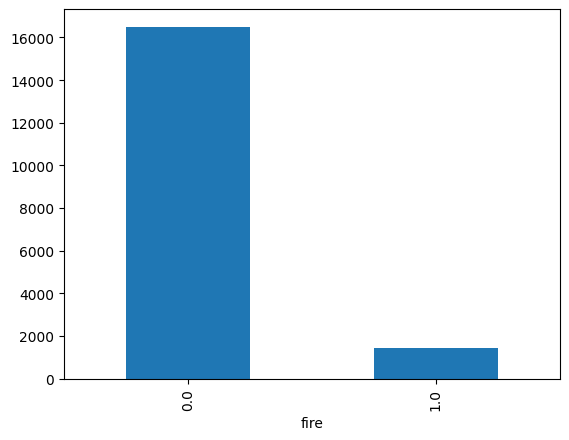

In [3]:
# 불이 안난 경우가 훨씬 많음
df['fire'].value_counts().plot.bar()

# 1. Random Undersampling

In [4]:
# 랜덤 언더샘플링으로 화재 발생하지 않은 지역 샘플링
shuffled_df = df.sample(frac=1, random_state=seed)

fire_df = shuffled_df.loc[shuffled_df['fire'] != 0]
non_fire_df = shuffled_df.loc[shuffled_df['fire'] == 0][:len(fire_df)]

norm_df = pd.concat([fire_df, non_fire_df])
rand_sub_df = norm_df.sample(frac=1, random_state=seed)

rand_sub_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire,fire
8437,3,0.071429,0.714286,0.040054,0.092166,0.075472,0.000000,0.303109,0.292011,0.371359,0.439338,0.010695,0.272727,0.071429,0.071429,0.0
11705,3,0.142857,0.357143,0.038427,0.086070,0.207547,0.000000,0.295337,0.283747,0.393204,0.560662,0.000000,0.212121,0.000000,0.000000,1.0
3015,11,0.214286,0.857143,0.024252,0.066975,0.000000,0.000000,0.544041,0.528926,0.580097,0.584559,0.000000,0.151515,0.000000,0.000000,0.0
17879,12,0.500000,0.642857,1.000000,1.000000,0.981132,0.333333,0.121762,0.143251,0.092233,0.104779,0.000000,0.242424,0.357143,0.357143,1.0
17513,9,0.857143,0.571429,0.104754,0.165997,0.471698,0.333333,0.759067,0.823691,0.737864,0.753676,0.000000,0.151515,0.071429,0.071429,1.0


<Axes: xlabel='fire'>

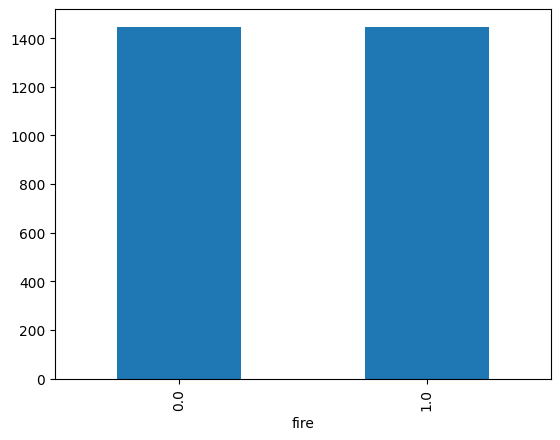

In [5]:
# 불이 난 경우와 안난 경우가 같아짐
rand_sub_df['fire'].value_counts().plot.bar()

<Axes: >

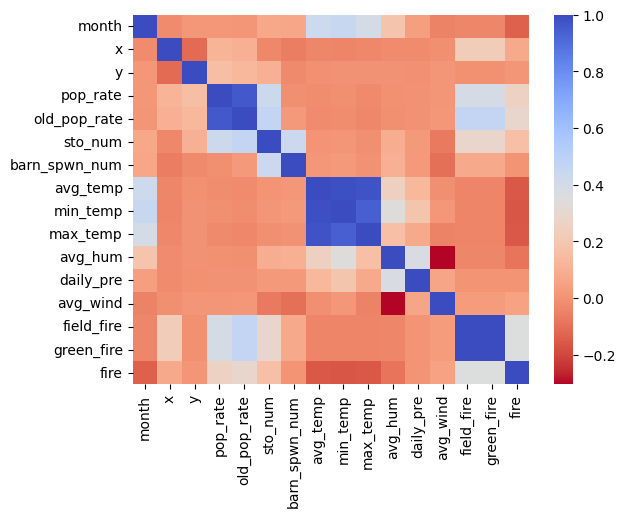

In [6]:
# 변수별 상관관계 분석
corr = rand_sub_df.corr()
sns.heatmap(corr, cmap='coolwarm_r')

In [7]:
# 변수별 상관관계 조사
corr['fire'].sort_values(ascending=False)

fire             1.000000
field_fire       0.350398
green_fire       0.350398
old_pop_rate     0.290467
pop_rate         0.253521
sto_num          0.161138
x                0.077616
avg_wind         0.047629
y                0.010616
daily_pre        0.005192
barn_spwn_num    0.001956
avg_hum         -0.087642
month           -0.141189
max_temp        -0.156878
avg_temp        -0.160180
min_temp        -0.163089
Name: fire, dtype: float64

In [71]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, average_precision_score

In [72]:
# train, test 데이터 스플릿
X = rand_sub_df.drop('fire', axis=1)
y = rand_sub_df['fire']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [73]:
# 모델 기본 파라미터로 학습
classifiers = {
    "로지스틱회귀": LogisticRegression(),
    "K최근접": KNeighborsClassifier(),
    "결정트리": DecisionTreeClassifier(),
    "랜덤포레스트": RandomForestClassifier()
}

for _, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "에서 학습 정확도", round(training_score.mean(), 2) * 100, "%")

LogisticRegression 에서 학습 정확도 68.0 %
KNeighborsClassifier 에서 학습 정확도 63.0 %
DecisionTreeClassifier 에서 학습 정확도 60.0 %
RandomForestClassifier 에서 학습 정확도 67.0 %


In [74]:
# 로지스틱회귀 하이퍼파라미터 튜닝
lr_params_under = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_grid_under = GridSearchCV(LogisticRegression(), lr_params_under)
lr_grid_under.fit(X_train, y_train)
lr_best_under = lr_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(lr_grid_under.best_score_ * 100), '파라미터:', lr_grid_under.best_params_)

최고예측정확도: 67.99% 파라미터: {'C': 100, 'penalty': 'l2'}


In [75]:
# K최근접 하이퍼파라미터 튜닝
kn_params_under = {"n_neighbors": [2, 3, 4], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

kn_grid_under = GridSearchCV(KNeighborsClassifier(), kn_params_under)
kn_grid_under.fit(X_train, y_train)
kn_best_under = kn_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(kn_grid_under.best_score_ * 100), '파라미터:', kn_grid_under.best_params_)

최고예측정확도: 63.84% 파라미터: {'algorithm': 'auto', 'n_neighbors': 3}


In [76]:
# 결정트리 하이퍼파라미터 튜닝
dt_params_under = {"criterion": ["gini", "entropy"], "max_depth": [2, 3, 4, 5], "min_samples_leaf": [5, 6, 7, 8, 9]}

dt_grid_under = GridSearchCV(DecisionTreeClassifier(), dt_params_under)
dt_grid_under.fit(X_train, y_train)
dt_best_under = dt_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(dt_grid_under.best_score_ * 100), '파라미터:', dt_grid_under.best_params_)

최고예측정확도: 66.74% 파라미터: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 6}


In [77]:
# 랜덤포레스트 하이퍼파라미터 튜닝
rf_params_under = { 'n_estimators' : [100], 'max_depth' : [4, 6, 8], 'min_samples_leaf' : [8, 12, 18, 20], 'min_samples_split' : [6, 8, 16]}

rf_grid_under = GridSearchCV(RandomForestClassifier(), rf_params_under)
rf_grid_under.fit(X_train, y_train)
rf_best_under = rf_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(rf_grid_under.best_score_ * 100), '파라미터:', rf_grid_under.best_params_)

최고예측정확도: 68.42% 파라미터: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}


In [78]:
# 모델 알고리즘 f1 스코어 cross validation
lr_score_f1_under = cross_val_score(lr_best_under, X_train, y_train, scoring='f1', cv=5).mean()
kn_score_f1_under = cross_val_score(kn_best_under, X_train, y_train, scoring='f1', cv=5).mean()
dt_score_f1_under = cross_val_score(dt_best_under, X_train, y_train, scoring='f1', cv=5).mean()
rf_score_f1_under = cross_val_score(rf_best_under, X_train, y_train, scoring='f1', cv=5).mean()

print('로지스틱 회귀 F1 스코어: {:.2f}%'.format(lr_score_f1_under * 100))
print('K최근접 F1 스코어: {:.2f}%'.format(kn_score_f1_under * 100))
print('결정트리 F1 스코어: {:.2f}%'.format(dt_score_f1_under * 100))
print('랜덤포레스트 F1 스코어: {:.2f}%'.format(rf_score_f1_under * 100))

로지스틱 회귀 F1 스코어: 66.61%
K최근접 F1 스코어: 64.20%
결정트리 F1 스코어: 67.71%
랜덤포레스트 F1 스코어: 68.58%


In [79]:
# 모델 알고리즘 ROC AUC 스코어 cross validation
lr_pred_under = cross_val_predict(lr_best_under, X_train, y_train, cv=5, method="decision_function")
kn_pred_under = cross_val_predict(kn_best_under, X_train, y_train, cv=5)
dt_pred_under = cross_val_predict(dt_best_under, X_train, y_train, cv=5)
rf_pred_under = cross_val_predict(rf_best_under, X_train, y_train, cv=5)

lr_score_auc_under = roc_auc_score(y_train, lr_pred_under)
kn_score_auc_under = roc_auc_score(y_train, kn_pred_under)
dt_score_auc_under = roc_auc_score(y_train, dt_pred_under)
rf_score_auc_under = roc_auc_score(y_train, rf_pred_under)

print('로지스틱 회귀 ROC AUC 스코어: {:.5f}'.format(lr_score_auc_under))
print('K최근접 ROC AUC 스코어: {:.5f}'.format(kn_score_auc_under))
print('결정트리 ROC AUC 스코어: {:.5f}'.format(dt_score_auc_under))
print('랜덤포레스트 ROC AUC 스코어: {:.5f}'.format(rf_score_auc_under))

로지스틱 회귀 ROC AUC 스코어: 0.74025
K최근접 ROC AUC 스코어: 0.63841
결정트리 ROC AUC 스코어: 0.66725
랜덤포레스트 ROC AUC 스코어: 0.68290


In [80]:
# 테스트 정확도
lr_test_pred_under = lr_best_under.predict(X_test)
kn_test_pred_under = kn_best_under.predict(X_test)
dt_test_pred_under = dt_best_under.predict(X_test)
rf_test_pred_under = rf_best_under.predict(X_test)

lr_score_acc_under = accuracy_score(y_test, lr_test_pred_under)
kn_score_acc_under = accuracy_score(y_test, kn_test_pred_under)
dt_score_acc_under = accuracy_score(y_test, dt_test_pred_under)
rf_score_acc_under = accuracy_score(y_test, rf_test_pred_under)

print('테스트 로지스틱 회귀 정확도: {:.2f}%'.format(lr_score_acc_under * 100))
print('테스트 K최근접 정확도: {:.2f}%'.format(kn_score_acc_under * 100))
print('테스트 결정트리 정확도: {:.2f}%'.format(dt_score_acc_under * 100))
print('테스트 랜덤포레스트 정확도: {:.2f}%'.format(rf_score_acc_under * 100))

테스트 로지스틱 회귀 정확도: 68.22%
테스트 K최근접 정확도: 65.28%
테스트 결정트리 정확도: 67.88%
테스트 랜덤포레스트 정확도: 67.70%


Undersampling에서는 랜덤포레스트가 적절해보임

# 2. SMOTE Oversampling

In [81]:
# 데이터셋 스플릿
X = df.drop('fire', axis=1)
y = df['fire']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

<Axes: xlabel='fire'>

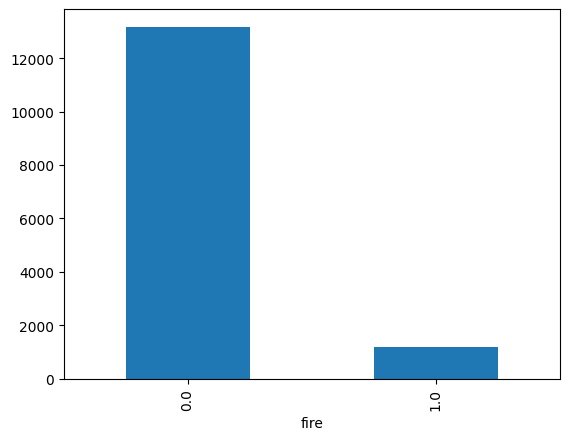

In [82]:
# 클래스 분포 확인
y_train.value_counts().plot.bar()

In [83]:
# SMOTE 기법으로 오버샘플링
sm = SMOTE(sampling_strategy='auto', random_state=seed)

over_X_train, over_y_train = sm.fit_resample(X_train, y_train)

<Axes: xlabel='fire'>

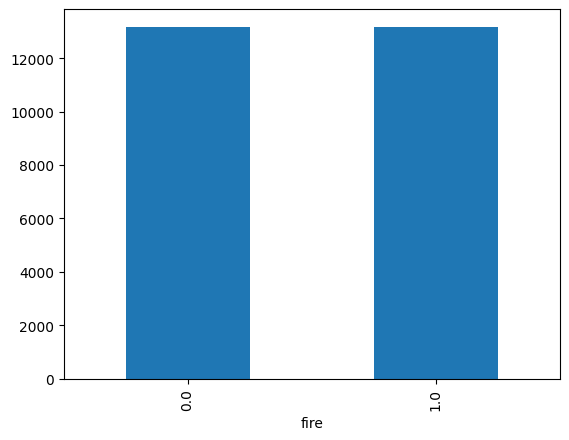

In [84]:
# 오버샘플링한 데이터 분포 확인
over_y_train.value_counts().plot.bar()

In [85]:
# 모델 기본 파라미터로 학습
classifiers = {
    "로지스틱회귀": LogisticRegression(),
    "K최근접": KNeighborsClassifier(),
    "결정트리": DecisionTreeClassifier(),
    "랜덤포레스트": RandomForestClassifier()
}

for _, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, over_X_train, over_y_train, cv=5)
    print(classifier.__class__.__name__, "에서 학습 정확도", round(training_score.mean(), 2) * 100, "%")

LogisticRegression 에서 학습 정확도 68.0 %
KNeighborsClassifier 에서 학습 정확도 86.0 %
DecisionTreeClassifier 에서 학습 정확도 90.0 %
RandomForestClassifier 에서 학습 정확도 95.0 %


In [86]:
# 로지스틱회귀 하이퍼파라미터 튜닝
lr_params_over = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_grid_over = GridSearchCV(LogisticRegression(), lr_params_over)
lr_grid_over.fit(over_X_train, over_y_train)
lr_best_over = lr_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(lr_grid_over.best_score_ * 100), '파라미터:', lr_grid_over.best_params_)

최고예측정확도: 68.07% 파라미터: {'C': 0.01, 'penalty': 'l2'}


In [87]:
# K최근접 하이퍼파라미터 튜닝
kn_params_over = {"n_neighbors": [2, 3, 4], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

kn_grid_over = GridSearchCV(KNeighborsClassifier(), kn_params_over)
kn_grid_over.fit(over_X_train, over_y_train)
kn_best_over = kn_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(kn_grid_over.best_score_ * 100), '파라미터:', kn_grid_over.best_params_)

최고예측정확도: 91.99% 파라미터: {'algorithm': 'auto', 'n_neighbors': 2}


In [88]:
# 결정트리 하이퍼파라미터 튜닝
dt_params_over = {"criterion": ["gini", "entropy"], "max_depth": [None], "min_samples_leaf": [1, 5, 6, 7, 8, 9]}

dt_grid_over = GridSearchCV(DecisionTreeClassifier(), dt_params_over)
dt_grid_over.fit(over_X_train, over_y_train)
dt_best_over = dt_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(dt_grid_over.best_score_ * 100), '파라미터:', dt_grid_over.best_params_)

최고예측정확도: 90.46% 파라미터: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}


In [89]:
# 랜덤포레스트 하이퍼파라미터 튜닝
rf_params_over = { 'n_estimators' : [100], 'max_depth' : [None], 'min_samples_leaf' : [1, 8, 12, 18, 20], 'min_samples_split' : [2, 6, 8, 16]}

rf_grid_over = GridSearchCV(RandomForestClassifier(), rf_params_over)
rf_grid_over.fit(over_X_train, over_y_train)
rf_best_over = rf_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(rf_grid_over.best_score_ * 100), '파라미터:', rf_grid_over.best_params_)

최고예측정확도: 95.06% 파라미터: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [90]:
# 모델 알고리즘 f1 스코어 cross validation
lr_score_f1_over = cross_val_score(lr_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
kn_score_f1_over = cross_val_score(kn_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
dt_score_f1_over = cross_val_score(dt_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
rf_score_f1_over = cross_val_score(rf_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()

print('로지스틱 회귀 F1 스코어: {:.2f}%'.format(lr_score_f1_over * 100))
print('K최근접 F1 스코어: {:.2f}%'.format(kn_score_f1_over * 100))
print('결정트리 F1 스코어: {:.2f}%'.format(dt_score_f1_over * 100))
print('랜덤포레스트 F1 스코어: {:.2f}%'.format(rf_score_f1_over * 100))

로지스틱 회귀 F1 스코어: 66.21%
K최근접 F1 스코어: 92.31%
결정트리 F1 스코어: 90.04%
랜덤포레스트 F1 스코어: 94.50%


In [91]:
# 모델 알고리즘 ROC AUC 스코어 cross validation
lr_pred_over = cross_val_predict(lr_best_over, over_X_train, over_y_train, cv=5, method="decision_function")
kn_pred_over = cross_val_predict(kn_best_over, over_X_train, over_y_train, cv=5)
dt_pred_over = cross_val_predict(dt_best_over, over_X_train, over_y_train, cv=5)
rf_pred_over = cross_val_predict(rf_best_over, over_X_train, over_y_train, cv=5)

lr_score_auc_over = roc_auc_score(over_y_train, lr_pred_over)
kn_score_auc_over = roc_auc_score(over_y_train, kn_pred_over)
dt_score_auc_over = roc_auc_score(over_y_train, dt_pred_over)
rf_score_auc_over = roc_auc_score(over_y_train, rf_pred_over)

print('로지스틱 회귀 ROC AUC 스코어: {:.5f}'.format(lr_score_auc_over))
print('K최근접 ROC AUC 스코어: {:.5f}'.format(kn_score_auc_over))
print('결정트리 ROC AUC 스코어: {:.5f}'.format(dt_score_auc_over))
print('랜덤포레스트 ROC AUC 스코어: {:.5f}'.format(rf_score_auc_over))

로지스틱 회귀 ROC AUC 스코어: 0.73802
K최근접 ROC AUC 스코어: 0.91987
결정트리 ROC AUC 스코어: 0.90583
랜덤포레스트 ROC AUC 스코어: 0.95159


In [93]:
# 테스트 정확도
lr_test_pred_over = lr_best_over.predict(X_test)
kn_test_pred_over = kn_best_over.predict(X_test)
dt_test_pred_over = dt_best_over.predict(X_test)
rf_test_pred_over = rf_best_over.predict(X_test)

lr_score_acc_over = accuracy_score(y_test, lr_test_pred_over)
kn_score_acc_over = accuracy_score(y_test, kn_test_pred_over)
dt_score_acc_over = accuracy_score(y_test, dt_test_pred_over)
rf_score_acc_over = accuracy_score(y_test, rf_test_pred_over)

print('테스트 로지스틱 회귀 정확도: {:.2f}%'.format(lr_score_acc_over * 100))
print('테스트 K최근접 정확도: {:.2f}%'.format(kn_score_acc_over * 100))
print('테스트 결정트리 정확도: {:.2f}%'.format(dt_score_acc_over * 100))
print('테스트 랜덤포레스트 정확도: {:.2f}%'.format(rf_score_acc_over * 100))

테스트 로지스틱 회귀 정확도: 73.18%
테스트 K최근접 정확도: 84.02%
테스트 결정트리 정확도: 84.88%
테스트 랜덤포레스트 정확도: 90.95%


Oversampling의 경우 랜덤포레스트 모델이 가장 성능이 좋음

In [94]:
# 랜덤포레스트 결과 종합 -> SMOTE Oversampling으로 데이터셋 샘플링하여 랜덤포레스트로 학습시킨 모델이 가장 좋음
results = [
    ['Random Undersampling', rf_score_f1_under, rf_score_auc_under, rf_score_acc_under],
    ['SMOTE Oversampling', rf_score_f1_over, rf_score_auc_over, rf_score_acc_over]
]

pd.DataFrame(results, columns=['sampling_method', 'train_f1_score', 'train_auc_score', 'test_accuracy'])


,sampling_method,train_f1_score,train_auc_score,test_accuracy
0,Random Undersampling,0.685790,0.682901,0.677029
1,SMOTE Oversampling,0.945019,0.951586,0.909496


In [ ]:
# 학습된 랜덤포레스트 모델 저장
import joblib 

joblib.dump(rf_best_over, 'rf_model_over.pkl')

# 3. 2023.06~2023.12 화재예측

In [6]:
# 데이터파일 불러오기
df_fire = pd.read_csv('./data/preprocessed_fire_data.csv')
df_buildings = pd.read_csv('./data/preprocessed_buildings.csv')
df_pop = pd.read_csv('./data/coorded_old_population.csv')
df_weather = pd.read_csv('./data/preprocessed_weather.csv')

In [9]:
# 모델 불러오기
import joblib
 
rf_best_over = joblib.load('./rf_model_over.pkl')

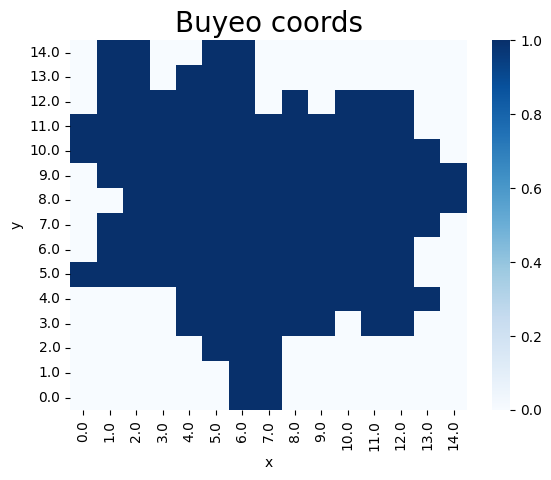

In [11]:
# 부여가 포함된 좌표만 걸러내기
# 인구분포 데이터와 화재 데이터를 결합하여 부여에 해당하는 좌표 얻기
df_pop_xy = df_pop.loc[:, ['x', 'y']]
df_fire_xy = df_fire.loc[:, ['x', 'y']]
df_buyeo = pd.concat([df_pop_xy, df_fire_xy])
df_buyeo = df_buyeo.drop_duplicates()
df_buyeo['val'] = 1
df_buyeo_heatmap = df_buyeo.pivot(index='y', columns='x', values='val').sort_index(ascending=False).fillna(0)
df_buyeo = df_buyeo.loc[:, ['x', 'y']]
ax = sns.heatmap(df_buyeo_heatmap, cmap='Blues')
plt.title('Buyeo coords', fontsize=20)
plt.show()

In [12]:
# 11년치 날씨데이터 평균내서 23년도 날씨로 예측
df_fut_weather = df_weather.groupby(['월']).mean().drop(columns=['년', '일']).reset_index()
df_fut_weather

,월,평균기온(°C),최저기온(°C),최고기온(°C),평균 상대습도\n(%),일강수량(mm),평균 풍속(m/s)
0,1,-1.385337,-6.638710,4.651320,70.536364,0.769208,1.095015
1,2,0.779100,-4.882637,6.999035,64.272669,1.268810,1.366238
2,3,6.487977,0.058944,13.654839,65.741056,1.687390,1.443695
3,4,12.153030,5.453333,19.492727,65.420909,3.007273,1.539697
4,5,17.850733,11.487683,24.984751,67.973314,2.524047,1.448387
5,6,22.465455,17.652727,28.330303,74.122424,3.181818,1.312727
6,7,25.499413,22.031378,30.218182,81.592082,8.357771,1.343988
7,8,26.061584,22.282991,30.991789,80.671554,8.670968,1.328446
8,9,20.905455,16.365152,26.711212,78.428485,4.710606,1.191515
9,10,14.124047,8.520235,21.224340,76.725513,2.747214,1.041935


In [13]:
# 좌표별 임야 화재 횟수 세기
df_field_fire = df_fire[df_fire['화재구분'] == '임야'].groupby(['x', 'y']).count().loc[:, ['화재구분']].reset_index()
df_field_fire.head()

,x,y,화재구분
0,0.0,5.0,1
1,0.0,10.0,2
2,1.0,5.0,3
3,1.0,6.0,1
4,1.0,7.0,2


In [14]:
# 좌표별 비닐하우스 화재 횟수 세기
df_green_fire = df_fire[df_fire['화재구분'] == '비닐하우스'].groupby(['x', 'y']).count().loc[:, ['화재구분']].reset_index()
df_green_fire.head()

,x,y,화재구분
0,0.0,11.0,2
1,1.0,5.0,1
2,1.0,6.0,2
3,1.0,10.0,1
4,1.0,11.0,1


In [15]:
# 날짜와 좌표의 모든 조합 구하기
import itertools

year = [2023]
month = list(np.arange(start=1, stop=13))
full_date = list(itertools.product(year, month))
buyeo_coords = df_buyeo.values.tolist()

date_coords = list(itertools.product(full_date, buyeo_coords))
len(date_coords)

1632

In [16]:
pred_feats = []

for date_coord in date_coords:
    feat = []
    # 날짜 및 좌표부터 추가: 년, 월, x, y
    feat.append(date_coord[0][0]) 
    feat.append(date_coord[0][1]) 
    feat.append(date_coord[1][0])
    feat.append(date_coord[1][1])

    # 인구수비율 및 노인인구수비율 추가: 인구수비율, 60세이상노인인구수비율
    pop_result =  df_pop[
        (df_pop['연도'] == 2022) &
        (df_pop['x'] == date_coord[1][0]) &
        (df_pop['y'] == date_coord[1][1])
    ]

    if len(pop_result) == 0:
        feat.append(0.)
        feat.append(0.)
    else:
        feat.append(pop_result.iloc[0]['인구수비율'])
        feat.append(pop_result.iloc[0]['60세이상노인인구수비율'])

    # 날짜 및 좌표별 창고개수 추가: 창고개수
    storage_date = int(str(2022) + str('{:02d}'.format(date_coord[0][1])) + str(15))
    storage_result = df_buildings.loc[
        (df_buildings['x'] == date_coord[1][0]) &
        (df_buildings['y'] == date_coord[1][1]) &
        (df_buildings['신고일'] <= storage_date) & 
        (df_buildings['실질적철거일'] >= storage_date) &
        (df_buildings['기타용도'] == '창고')
    ]

    feat.append(len(storage_result))

    # 날짜 및 좌표별 축사, 균사개수 추가: 축균사개수
    barn_spawn_date = int(str(2022) + str('{:02d}'.format(date_coord[0][1])) + str(15))
    barn_spawn_result = df_buildings.loc[
        (df_buildings['x'] == date_coord[1][0]) &
        (df_buildings['y'] == date_coord[1][1]) &
        (df_buildings['신고일'] <= barn_spawn_date) & 
        (df_buildings['실질적철거일'] >= barn_spawn_date) &
        ((df_buildings['기타용도'] == '축사') | (df_buildings['기타용도'] == '균사'))
    ]

    feat.append(len(barn_spawn_result))
    
    # 날씨 데이터 추가: 평균기온, 최저기온, 최고기온, 평균 상대습도, 일강수량, 평균 풍속
    weather_result = df_fut_weather[
        df_fut_weather['월'] == date_coord[0][1]
    ]

    feat.append(weather_result.iloc[0]['평균기온(°C)'])
    feat.append(weather_result.iloc[0]['최저기온(°C)'])
    feat.append(weather_result.iloc[0]['최고기온(°C)'])
    feat.append(weather_result.iloc[0]['평균 상대습도\n(%)'])
    feat.append(weather_result.iloc[0]['일강수량(mm)'])
    feat.append(weather_result.iloc[0]['평균 풍속(m/s)'])

    # 좌표별 임야화재횟수 추가: 임야화재횟수
    field_result = df_field_fire[
        (df_field_fire['x'] == date_coord[1][0]) & 
        (df_field_fire['y'] == date_coord[1][1])
    ]

    if len(field_result) == 0:
        feat.append(0.)
    else:
        feat.append(field_result.iloc[0]['화재구분'])

    # 좌표별 비닐하우스화재횟수 추가: 비닐하우스화재횟수
    green_result = df_green_fire[
        (df_field_fire['x'] == date_coord[1][0]) & 
        (df_field_fire['y'] == date_coord[1][1])
    ]

    if len(field_result) == 0:
        feat.append(0.)
    else:
        feat.append(field_result.iloc[0]['화재구분'])

    pred_feats.append(feat)

In [17]:
# 년, 월, x, y, 인구수비율, 60세이상노인인구수비율, 창고개수, 축균사개수, 평균기온, 최저기온, 최고기온, 평균상대습도, 
# 일강수량, 평균풍속, 임야화재횟수, 비닐하우스화재횟수
fut_df = pd.DataFrame(pred_feats, columns=[
    'year', 'month', 'x', 'y', 'pop_rate', 'old_pop_rate', 'sto_num', 'barn_spwn_num', 'avg_temp', 'min_temp', 'max_temp', 'avg_hum', 
    'daily_pre', 'avg_wind', 'field_fire', 'green_fire'
])
print(len(fut_df))
fut_df.head()

1632


,year,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire
0,2023,1,0.0,11.0,0.010901,0.012014,5,0,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,0.0,0.0
1,2023,1,1.0,5.0,0.004584,0.006429,8,1,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,3.0,3.0
2,2023,1,1.0,6.0,0.005604,0.007338,8,2,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,1.0,1.0
3,2023,1,1.0,7.0,0.002089,0.002987,6,1,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,2.0,2.0
4,2023,1,1.0,9.0,0.001263,0.001916,7,0,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,0.0,0.0


In [18]:
# 전체 데이터를 스케일링 위해 가져오기
full_df = pd.read_csv('./data/non_scaled_data.csv').drop(columns=['fire'])
print(len(full_df))
full_df.head()

17952


,year,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire
0,2012,1,0.0,11.0,0.012300,0.012723,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,0.0,0.0
1,2012,1,1.0,5.0,0.004109,0.007010,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,3.0,3.0
2,2012,1,1.0,6.0,0.005297,0.008671,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,1.0,1.0
3,2012,1,1.0,7.0,0.001939,0.002958,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,2.0,2.0
4,2012,1,1.0,9.0,0.001038,0.001661,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,0.0,0.0


In [19]:
# 전체 데이터와 예측할 데이터를 같이 묶기
fut_df = pd.concat([fut_df, full_df], axis=0)

In [20]:
# 전체 데이터를 포함하여 MinMaxScaler로 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
fut_df['x'] = scaler.fit_transform(fut_df['x'].values.reshape(-1, 1))
fut_df['y'] = scaler.fit_transform(fut_df['y'].values.reshape(-1, 1))
fut_df['pop_rate'] = scaler.fit_transform(fut_df['pop_rate'].values.reshape(-1, 1))
fut_df['old_pop_rate'] = scaler.fit_transform(fut_df['old_pop_rate'].values.reshape(-1, 1))
fut_df['sto_num'] = scaler.fit_transform(fut_df['sto_num'].values.reshape(-1, 1))
fut_df['barn_spwn_num'] = scaler.fit_transform(fut_df['barn_spwn_num'].values.reshape(-1, 1))
fut_df['avg_temp'] = scaler.fit_transform(fut_df['avg_temp'].values.reshape(-1, 1))
fut_df['min_temp'] = scaler.fit_transform(fut_df['min_temp'].values.reshape(-1, 1))
fut_df['max_temp'] = scaler.fit_transform(fut_df['max_temp'].values.reshape(-1, 1))
fut_df['avg_hum'] = scaler.fit_transform(fut_df['avg_hum'].values.reshape(-1, 1))
fut_df['daily_pre'] = scaler.fit_transform(fut_df['daily_pre'].values.reshape(-1, 1))
fut_df['avg_wind'] = scaler.fit_transform(fut_df['avg_wind'].values.reshape(-1, 1))
fut_df['field_fire'] = scaler.fit_transform(fut_df['field_fire'].values.reshape(-1, 1))
fut_df['green_fire'] = scaler.fit_transform(fut_df['green_fire'].values.reshape(-1, 1))

In [21]:
# 예측할 데이터만 떼서 미래데이터 준비
fut_df = fut_df.iloc[:1632].drop(columns=['year'])
fut_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire
0,1,0.000000,0.785714,0.087905,0.165105,0.094340,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000
1,1,0.071429,0.357143,0.036964,0.088353,0.150943,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.214286,0.214286
2,1,0.071429,0.428571,0.045193,0.100848,0.150943,0.333333,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.071429,0.071429
3,1,0.071429,0.500000,0.016850,0.041053,0.113208,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.142857,0.142857
4,1,0.071429,0.642857,0.010188,0.026328,0.132075,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000


In [23]:
# 데이터로 예측 진행
fut_y = rf_best_over.predict(fut_df)
fut_df['fire'] = fut_y
fut_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire,fire
0,1,0.000000,0.785714,0.087905,0.165105,0.094340,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000,0.0
1,1,0.071429,0.357143,0.036964,0.088353,0.150943,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.214286,0.214286,0.0
2,1,0.071429,0.428571,0.045193,0.100848,0.150943,0.333333,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.071429,0.071429,0.0
3,1,0.071429,0.500000,0.016850,0.041053,0.113208,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.142857,0.142857,0.0
4,1,0.071429,0.642857,0.010188,0.026328,0.132075,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000,0.0


In [24]:
# 예측한 데이터들의 좌표를 스케일링 이전으로 변환
df_map = fut_df.loc[:, ['month', 'x', 'y', 'fire']]
df_map['x'] = (df_map['x'] * 14).apply(lambda x: np.ceil(x))
df_map['y'] = (df_map['y'] * 14).apply(lambda x: np.ceil(x))
df_map.head()

,month,x,y,fire
0,1,0.0,11.0,0.0
1,1,1.0,5.0,0.0
2,1,1.0,6.0,0.0
3,1,1.0,7.0,0.0
4,1,1.0,9.0,0.0


In [25]:
# 월별 화재데이터 예측
map_heatmap_7 = df_map[df_map['month'] == 7].pivot(index='y', columns='x', values='fire').sort_index(ascending=True).fillna(0)
map_heatmap_8 = df_map[df_map['month'] == 8].pivot(index='y', columns='x', values='fire').sort_index(ascending=True).fillna(0)
map_heatmap_9 = df_map[df_map['month'] == 9].pivot(index='y', columns='x', values='fire').sort_index(ascending=True).fillna(0)
map_heatmap_10 = df_map[df_map['month'] == 10].pivot(index='y', columns='x', values='fire').sort_index(ascending=True).fillna(0)
map_heatmap_11 = df_map[df_map['month'] == 11].pivot(index='y', columns='x', values='fire').sort_index(ascending=True).fillna(0)
map_heatmap_12 = df_map[df_map['month'] == 12].pivot(index='y', columns='x', values='fire').sort_index(ascending=True).fillna(0)

Text(0.5, 1.0, '2023.12')

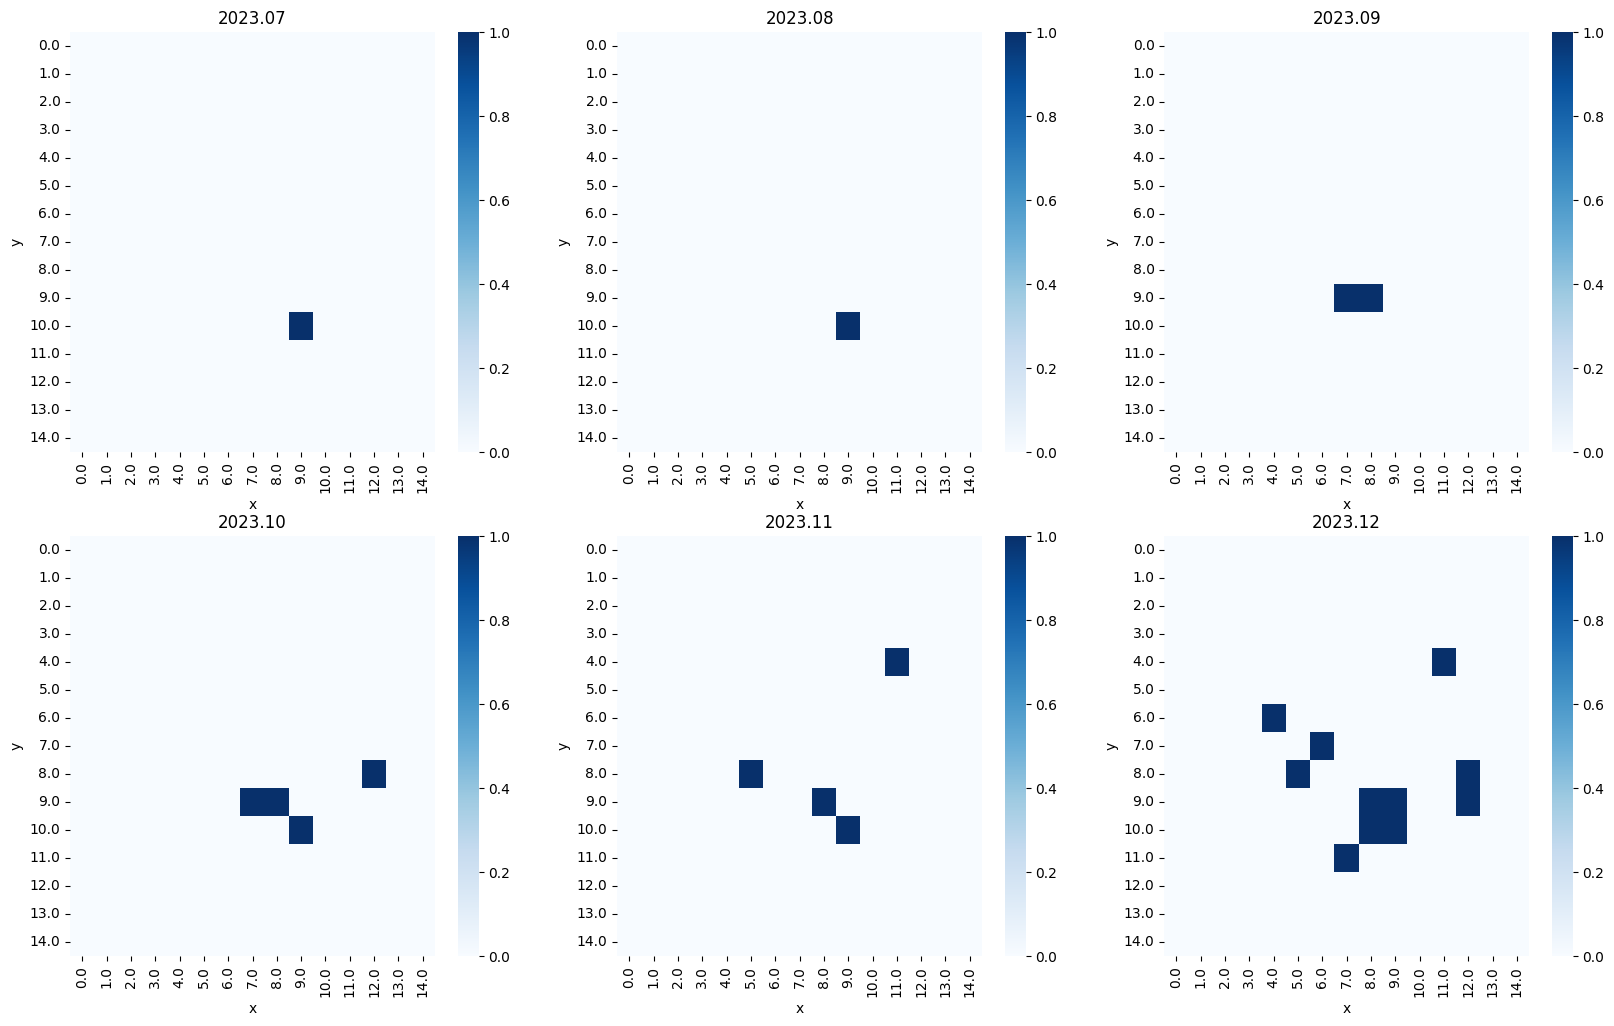

In [27]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 12))

sns.heatmap(map_heatmap_7, cmap='Blues', ax=ax[0][0])
sns.heatmap(map_heatmap_8, cmap='Blues', ax=ax[0][1])
sns.heatmap(map_heatmap_9, cmap='Blues', ax=ax[0][2])
sns.heatmap(map_heatmap_10, cmap='Blues', ax=ax[1][0])
sns.heatmap(map_heatmap_11, cmap='Blues', ax=ax[1][1])
sns.heatmap(map_heatmap_12, cmap='Blues', ax=ax[1][2])

ax[0][0].set_title('2023.07')
ax[0][1].set_title('2023.08')
ax[0][2].set_title('2023.09')
ax[1][0].set_title('2023.10')
ax[1][1].set_title('2023.11')
ax[1][2].set_title('2023.12')

In [228]:
# 예측된 2023년 화재 정보 저장
df_map.to_csv('./data/2023_prediction.csv', encoding='utf-8-sig', index=False)

# 4. 지도에 예측된 화재격자 표시

In [1]:
import folium
import numpy as np
import pandas as pd

In [2]:
# 2023년 예측한 결과 데이터 불러오기
df_map = pd.read_csv('./data/2023_prediction.csv')
df_map = df_map[df_map['month'] > 6]
df_map.head()

,month,x,y,fire
816,7,0.0,11.0,0.0
817,7,1.0,5.0,0.0
818,7,1.0,6.0,0.0
819,7,1.0,7.0,0.0
820,7,1.0,9.0,0.0


In [3]:
# 부여 동서남북 가장 끝 좌표
LOWER = 36.0721
LEFT = 126.6796
UPPER = 36.3865
RIGHT = 127.07

In [4]:
# 15, 15 좌표를 원래의 위도, 경도 좌표계로 변환
df_map['lon'] = (RIGHT - LEFT) * df_map['x'] / 15. + LEFT 
df_map['lat'] = (UPPER - LOWER) * df_map['y'] / 15. + LOWER
df_map.head()

,month,x,y,fire,lon,lat
816,7,0.0,11.0,0.0,126.679600,36.30266
817,7,1.0,5.0,0.0,126.705627,36.17690
818,7,1.0,6.0,0.0,126.705627,36.19786
819,7,1.0,7.0,0.0,126.705627,36.21882
820,7,1.0,9.0,0.0,126.705627,36.26074


In [5]:
# 웹에서 사용할 csv 파일 위해 각 격자별 남서, 북동 좌표 계산 후 저장
xh = (RIGHT - LEFT) / 30.
yh = (UPPER - LOWER) / 30.

df_map['sw_lat'] = df_map['lat'] - yh
df_map['sw_lon'] = df_map['lon'] - xh

df_map['ne_lat'] = df_map['lat'] + yh
df_map['ne_lon'] = df_map['lon'] + xh

df_map.head()

,month,x,y,fire,lon,lat,sw_lat,sw_lon,ne_lat,ne_lon
816,7,0.0,11.0,0.0,126.679600,36.30266,36.29218,126.666587,36.31314,126.692613
817,7,1.0,5.0,0.0,126.705627,36.17690,36.16642,126.692613,36.18738,126.718640
818,7,1.0,6.0,0.0,126.705627,36.19786,36.18738,126.692613,36.20834,126.718640
819,7,1.0,7.0,0.0,126.705627,36.21882,36.20834,126.692613,36.22930,126.718640
820,7,1.0,9.0,0.0,126.705627,36.26074,36.25026,126.692613,36.27122,126.718640


In [6]:
# 웹에서 사용할 예측결과 저장
df_map.loc[:, ['month', 'sw_lat', 'sw_lon', 'ne_lat', 'ne_lon', 'fire']].to_csv('./data/2023_prediction_web.csv', encoding='utf-8-sig', index=False)

In [8]:
# 사각형 폴리곤 구성 꼭짓점 계산
def get_rectangle_points(lat, lon):
    x_half = (RIGHT - LEFT) / 30.
    y_half = (UPPER - LOWER) / 30.

    points = [
        [lat - y_half, lon - x_half],
        [lat + y_half, lon - x_half],
        [lat + y_half, lon + x_half],
        [lat - y_half, lon + x_half],
    ]

    return points

In [9]:
# month 변수 조정하여 2023.07~2023.12까지 화재 예측
gmap = folium.Map(location=((LOWER + UPPER) / 2, (LEFT + RIGHT) / 2), zoom_start=10)

month = 12

for idx in df_map[df_map['month'] == month].index:
    points = get_rectangle_points(df_map.loc[idx, 'lat'], df_map.loc[idx, 'lon'])

    if df_map.loc[idx, 'fire'] == 0.:
        folium.Polygon(locations=points, tooltip='Fire', opacity=0.3).add_to(gmap)
    else:
        folium.Polygon(locations=points, tooltip='Fire', opacity=0.3, fill=True, fillColor='red', fillOpacity=0.3).add_to(gmap)

gmap